In [6]:
pip install albumentations

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached stringzilla-3.12.5-cp313-cp313-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (80 kB)
  Using cached simsimd-6.4.9-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (66 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x

In [15]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from segmentation_models_pytorch import Unet
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2


In [16]:

class ECGDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.augment     = augment

        self.IMG_HEIGHT = 640
        self.IMG_WIDTH  = 1024
        MAX_SIDE = max(self.IMG_HEIGHT, self.IMG_WIDTH)

        # spatial + color augmentations
        self.train_transform = A.Compose([
            A.LongestMaxSize(max_size=MAX_SIDE),
            A.PadIfNeeded(min_height=self.IMG_HEIGHT,
                          min_width =self.IMG_WIDTH,
                          border_mode=cv2.BORDER_CONSTANT,
                          value=0, mask_value=0),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
            A.ElasticTransform(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.6),
            A.Normalize(),
            ToTensorV2()
        ])

        # only spatial + normalize
        self.val_transform = A.Compose([
            A.LongestMaxSize(max_size=MAX_SIDE),
            A.PadIfNeeded(min_height=self.IMG_HEIGHT,
                          min_width =self.IMG_WIDTH,
                          border_mode=cv2.BORDER_CONSTANT,
                          value=0, mask_value=0),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # load
        img_path  = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Mask failed to read: {mask_path}")

        # choose transform
        if self.augment:
            aug = self.train_transform(image=image, mask=mask)
        else:
            aug = self.val_transform(image=image, mask=mask)

        image = aug['image']
        mask  = aug['mask'].unsqueeze(0).float()  # [1,H,W]

        return image, mask

In [17]:
# === Paths ===
WEIGHTS_PATH = '../../models/unet-binary-masking.pth'  # Update if needed
IMAGE_DIR = '../data/image'
MASK_DIR = '../data/mask-bmp'
SAVE_DIR = '../results'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Constants ===
BATCH_SIZE = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# === Load dataset ===

images = sorted(glob.glob(os.path.join(IMAGE_DIR, '*.png')))
masks = []
valid_images = []

for img_path in images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(MASK_DIR, base + '.bmp')
    if os.path.exists(mask_path):
        valid_images.append(img_path)
        masks.append(mask_path)

# Use only test split
_, temp_imgs, _, temp_masks = train_test_split(valid_images, masks, test_size=0.3, random_state=42)
_, test_imgs, _, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5, random_state=42)

test_ds = ECGDataset(test_imgs, test_masks, augment=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

/tmp/ipykernel_11453/1375675498.py:14: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,
/tmp/ipykernel_11453/1375675498.py:30: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,


In [20]:
# ---- Load model ----
from segmentation_models_pytorch import Unet

model = Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model = model.to(DEVICE)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [23]:
# ---- Evaluate ----
def evaluate(model, loader):
    model.eval()
    iou_total = 0
    dice_total = 0
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = torch.sigmoid(model(images)) > 0.5

            intersection = (outputs & masks.bool()).float().sum((1, 2, 3))
            union = (outputs | masks.bool()).float().sum((1, 2, 3))
            iou = (intersection / (union + 1e-7)).mean().item()

            dice = (2 * intersection / (outputs.float().sum((1,2,3)) + masks.sum((1,2,3)) + 1e-7)).mean().item()

            iou_total += iou
            dice_total += dice
            count += 1

    print(f"Mean IoU: {iou_total / count:.4f}, Mean Dice: {dice_total / count:.4f}")

evaluate(model, test_loader)

Mean IoU: 0.8131, Mean Dice: 0.8870


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


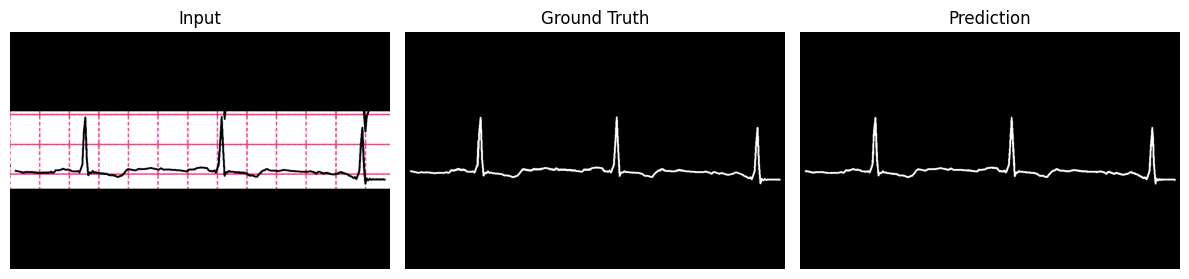

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


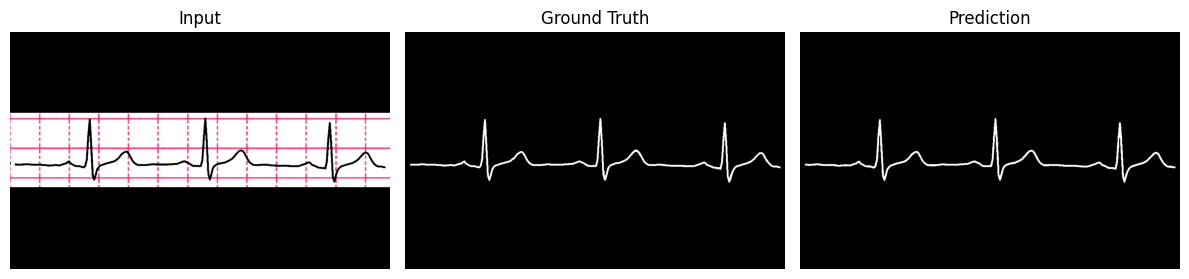

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


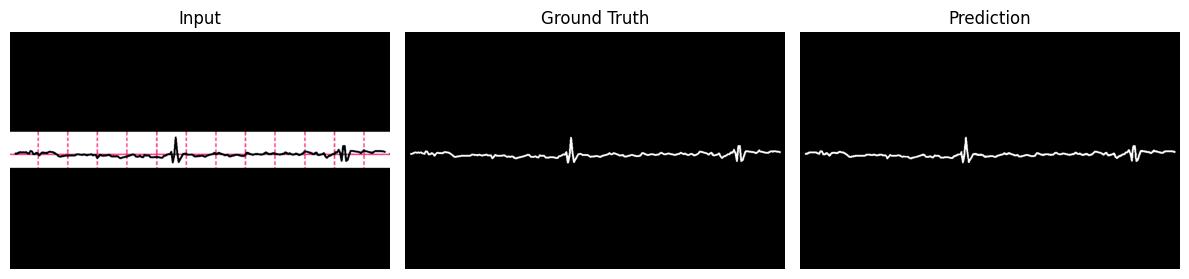

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


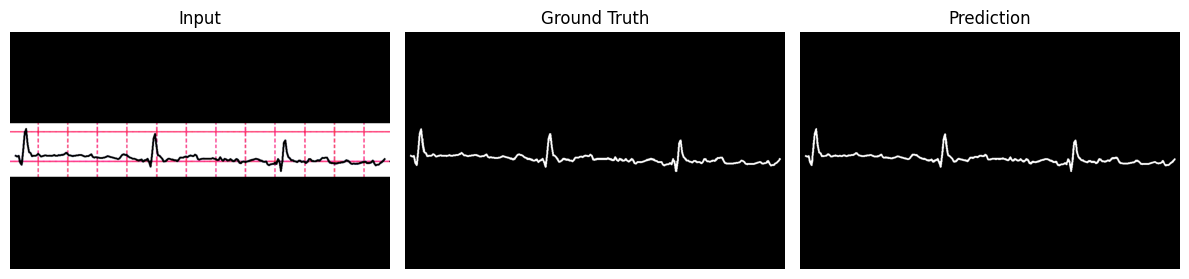

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


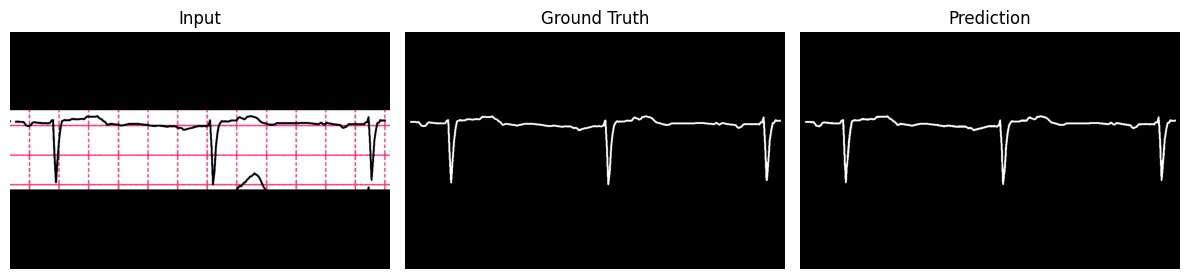

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


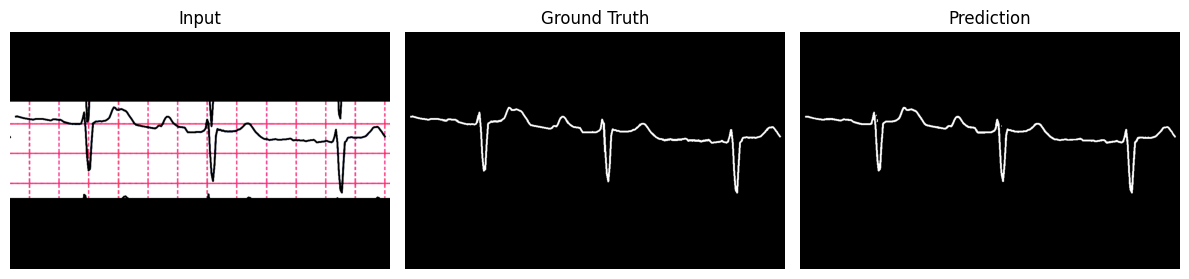

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


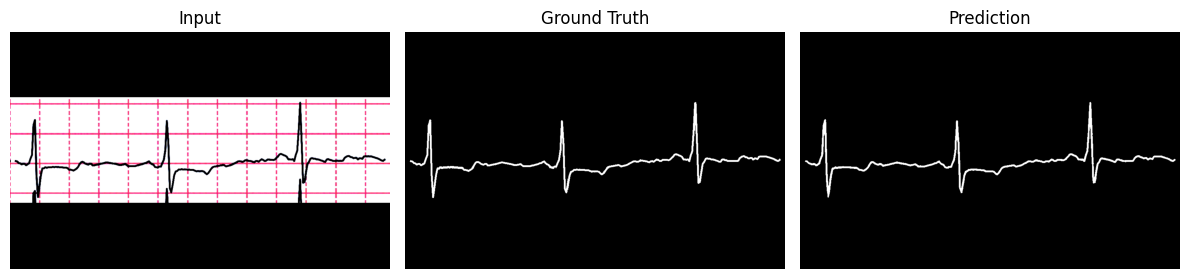

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


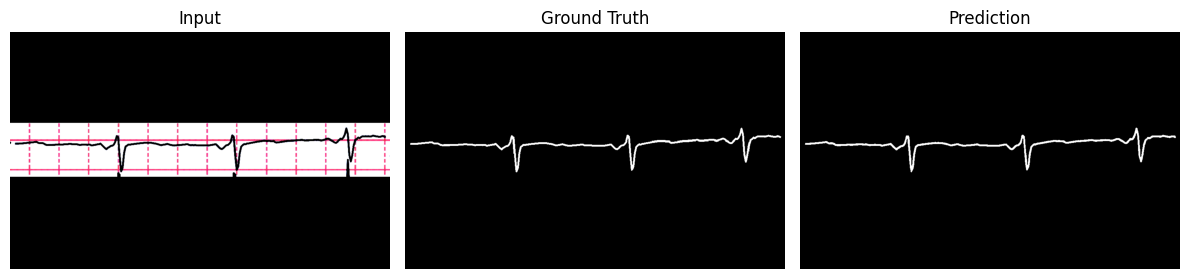

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


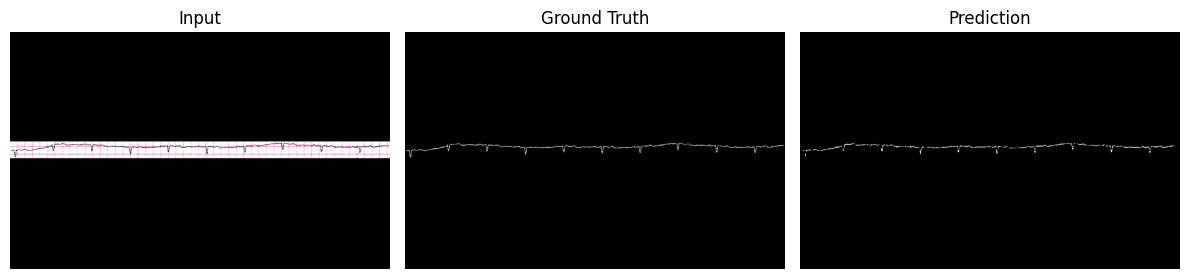

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


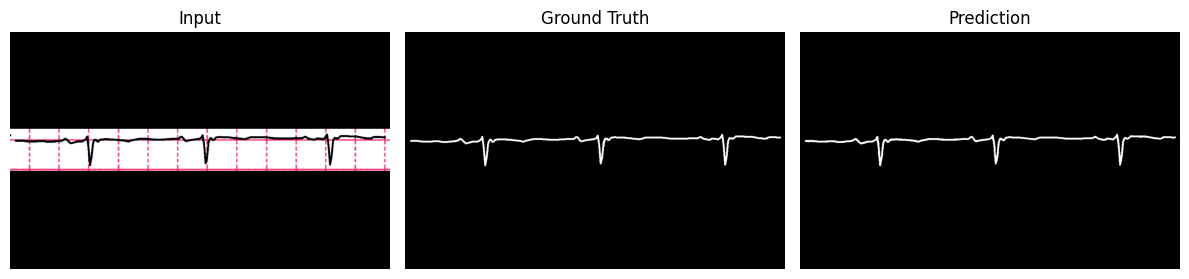

In [22]:
# ---- Visualize & Save Predictions ----
def visualize_and_save_predictions(model, dataloader, save_dir="./unet_results/test_preds", num_images=10):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = torch.sigmoid(model(images)) > 0.5  # Binarize

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return

                img = images[i].cpu()
                true_mask = masks[i]
                pred_mask = outputs[i].float()

                # Save individual images
                save_image(img, os.path.join(save_dir, f"{images_shown}_input.png"))
                save_image(true_mask, os.path.join(save_dir, f"{images_shown}_gt.png"))
                save_image(pred_mask, os.path.join(save_dir, f"{images_shown}_pred.png"))

                # Optional: Display
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img.permute(1, 2, 0))
                axs[0].set_title("Input")
                axs[1].imshow(true_mask[0].cpu(), cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred_mask[0].cpu(), cmap="gray")
                axs[2].set_title("Prediction")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                images_shown += 1

visualize_and_save_predictions(model, test_loader)